In [63]:
import pyro
import pyro.distributions as dist
import torch
import logging


# define ssm by hand

In [64]:
def ssm():
    # consts
    trans_mat = torch.eye(2)
    obs_mat = torch.eye(2) 

    duration = 3

    x = []
    z = []
    init_dist = dist.Normal(loc=torch.zeros(2), scale=1.).to_event(1)
    z.append(pyro.sample('z_0', init_dist))
    # x.append(pyro.sample(f'x_0', dist.Normal(loc=z[0] @ obs_mat, scale=1.).to_event(1)))
    
    for t in range(duration):
        z.append(pyro.sample(f'z_{t+1}', dist.Normal(loc=z[t] @ trans_mat, scale=1.).to_event(1)))
        x.append(pyro.sample(f'x_{t}', dist.Normal(loc=z[t] @ obs_mat, scale=1.).to_event(1)))


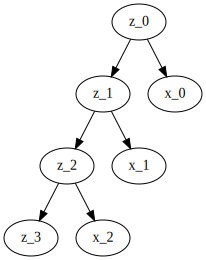

In [65]:
pyro.render_model(ssm) # we can render simplest model!

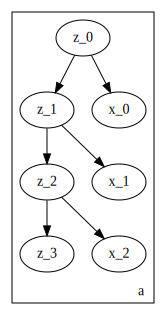

In [66]:
# Also, we can render plated SSM!!
def mo():
    with pyro.plate('a', 7):
        ssm()

pyro.render_model(mo)

## Hierarchical LGSSM

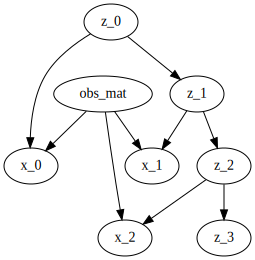

In [67]:
# And then, observation matrix is also "latentized!" 
def ssm_bayes_obsmat():
    # consts
    trans_mat = torch.eye(2)
    obs_mat = pyro.sample('obs_mat', dist.Normal(loc=torch.zeros(2,2), scale=1.).to_event(1))

    duration = 3

    x = []
    z = []
    init_dist = dist.Normal(loc=torch.zeros(2), scale=1.).to_event(1)
    z.append(pyro.sample('z_0', init_dist))
    # x.append(pyro.sample(f'x_0', dist.Normal(loc=z[0] @ obs_mat, scale=1.).to_event(1)))
    
    for t in range(duration):
        z.append(pyro.sample(f'z_{t+1}', dist.Normal(loc=z[t] @ trans_mat, scale=1.).to_event(1)))
        x.append(pyro.sample(f'x_{t}', dist.Normal(loc=z[t] @ obs_mat, scale=1.).to_event(1)))


pyro.render_model(ssm_bayes_obsmat)


## Plate of latent observation matrix model

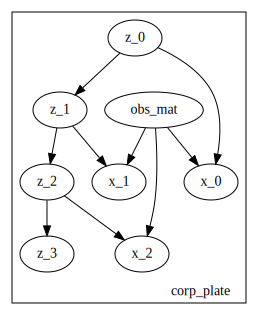

In [68]:
# dim=-2 is required!
def mo():
    with pyro.plate('corp_plate', 7, dim=-2):
        ssm_bayes_obsmat()

pyro.render_model(mo)

x[-1].shape:  torch.Size([7, 1, 2])
x.shape torch.Size([7, 3, 2])


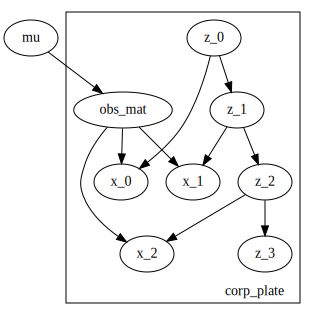

In [69]:
def ssm_bayes_hie(mu):
    # consts
    dim_features = 2
    trans_mat = torch.eye(dim_features)
    obs_mat = pyro.sample('obs_mat', dist.Normal(loc=torch.zeros(dim_features, dim_features) + mu, scale=1.).to_event(1))

    duration = 3

    x = []
    z = []
    init_dist = dist.Normal(loc=torch.zeros(dim_features), scale=1.).to_event(1)
    z.append(pyro.sample('z_0', init_dist))
    # x.append(pyro.sample(f'x_0', dist.Normal(loc=z[0] @ obs_mat, scale=1.).to_event(1)))
    
    for t in range(duration):
        z.append(pyro.sample(f'z_{t+1}', dist.Normal(loc=z[t] @ trans_mat, scale=1.).to_event(1)))
        x.append(pyro.sample(f'x_{t}', dist.Normal(loc=z[t] @ obs_mat, scale=1.).to_event(1)))

    # assert shape == (duration, dim_features)
    print('x[-1].shape: ', x[-1].shape)
    x = torch.concat(x, dim=-2) # concat time dimension, not batch 
    print('x.shape', x.shape)
    assert x.shape[-2] == duration
    assert x.shape[-1] == dim_features

    return x 


def mo () :
    mu = pyro.sample('mu', dist.Normal(loc=0., scale=1.))
    
    with pyro.plate('corp_plate', 7, dim=-2):
        return ssm_bayes_hie(mu)

pyro.render_model(mo)



In [70]:
# fails single call
ssm_bayes_hie(0)

x[-1].shape:  torch.Size([2])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)

In [ ]:
# passes batched call
mo().shape

torch.Size([7, 3, 2])

### Taking into acount observations

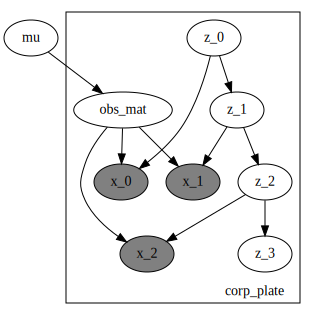

In [71]:
def ssm_bayes_hie_obs(mu, obs: torch.Tensor) -> torch.Tensor:
    # consts
    dim_features = 2
    trans_mat = torch.eye(dim_features)
    obs_mat = pyro.sample('obs_mat', dist.Normal(loc=torch.zeros(dim_features, dim_features) + mu, scale=1.).to_event(1))

    duration = 3

    assert obs.shape[-2] == duration
    # print(obs.shape)

    x = []
    z = []
    init_dist = dist.Normal(loc=torch.zeros(dim_features), scale=1.).to_event(1)
    z.append(pyro.sample('z_0', init_dist))
    # x.append(pyro.sample(f'x_0', dist.Normal(loc=z[0] @ obs_mat, scale=1.).to_event(1)))
    
    for t in range(duration):
        z.append(pyro.sample(f'z_{t+1}', dist.Normal(loc=z[t] @ trans_mat, scale=1.).to_event(1)))
        x.append(pyro.sample(f'x_{t}', 
        dist.Normal(loc=z[t] @ obs_mat, scale=1.).to_event(1),
        obs=obs[:, t, :].unsqueeze(1)
        )
        )

    # assert shape == (duration, dim_features)
    # print('x[-1].shape: ', x[-1].shape)
    x = torch.concat(x, dim=-2) # concat time dimension, not batch 
    # print('x.shape', x.shape)
    assert x.shape[-2] == duration
    assert x.shape[-1] == dim_features

    return x 


def mo (data=None) :
    mu = pyro.sample('mu', dist.Normal(loc=0., scale=1.))
    n_corps = 7
    duration = 3
    dim_x = 2

    if data is None:
        data = torch.zeros(n_corps, duration, dim_x)

    with pyro.plate('corp_plate', n_corps, dim=-2):
        return ssm_bayes_hie_obs(mu, obs=data)

pyro.render_model(mo)



In [ ]:
mo()

torch.Size([7, 3, 2])


tensor([[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]])

In [ ]:
auto_guide = pyro.infer.autoguide.AutoNormal(mo)

In [ ]:
adam = pyro.optim.Adam({'lr': 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(mo, auto_guide, adam, elbo)

In [ ]:
data = torch.arange(2*3*7, dtype=torch.float32).reshape(7, 3, 2)

In [76]:
# train loop
pyro.clear_param_store()

losses = []
for step in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    if step %100 == 0:
        logging.warning(f'Elbo loss: {loss:.5f}')
        print(f'Elbo loss: {loss:.5f}')

Elbo loss: 259.84785


Elbo loss: 268.53449


Elbo loss: 263.55105


Elbo loss: 256.38533


Elbo loss: 252.36207


Elbo loss: 266.76480


Elbo loss: 247.00840


Elbo loss: 250.14394


Elbo loss: 260.74370


Elbo loss: 249.18304


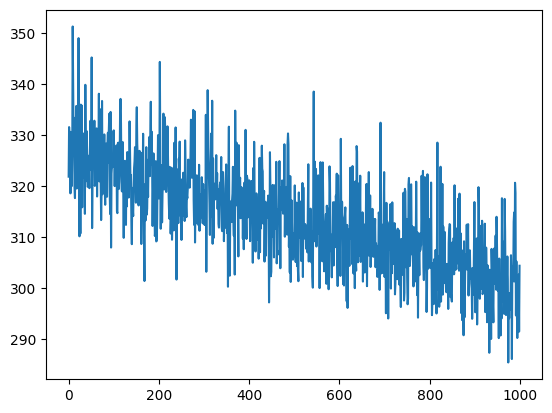

In [74]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [77]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.mu 3.0259652
AutoNormal.scales.mu 0.18614285
AutoNormal.locs.obs_mat [[[2.5742607  2.518633  ]
  [2.3491657  2.9534688 ]]

 [[2.9249225  3.2406986 ]
  [2.5168626  2.4881847 ]]

 [[2.5856922  2.622353  ]
  [3.6812148  3.8758328 ]]

 [[4.2252455  4.4284244 ]
  [2.2983422  2.3427596 ]]

 [[3.6650443  3.8624172 ]
  [3.7958488  4.0140195 ]]

 [[0.9355467  0.9118412 ]
  [5.49375    5.7194963 ]]

 [[5.9645495  6.1076493 ]
  [0.31764704 0.29497263]]]
AutoNormal.scales.obs_mat [[[0.877528   0.81567883]
  [0.5635843  0.53774524]]

 [[0.20708776 0.18244024]
  [0.96136105 0.8265655 ]]

 [[0.78795695 0.8827335 ]
  [0.16665772 0.16705126]]

 [[0.13656078 0.14044595]
  [0.6986431  0.83403647]]

 [[0.16760558 0.18031158]
  [0.188053   0.17148472]]

 [[0.25938034 0.31380686]
  [0.09060752 0.09046331]]

 [[0.08286975 0.08845931]
  [0.17013377 0.18195304]]]
AutoNormal.locs.z_0 [[[-0.05603568  0.1344153 ]]

 [[ 1.6923114   0.32018918]]

 [[ 0.662729    2.9327602 ]]

 [[ 3.9261234   0.58922

In [ ]:
## Create data
## learn data

In [ ]:
res = mo()
print(res.shape)

torch.Size([7, 3, 2])


In [ ]:
# What is the output shape of this model?
n_corps = 3 # 200 for real usecase
duration = 11
dim_features = 5 # 45 for real usecase
output = torch.zeros((n_corps, duration, dim_features))

## Generic Liner Gaussian State Space Models

In [ ]:
#import pyro.contrib.timeseries as timeseries
from pyro.contrib.timeseries import GenericLGSSM

In [ ]:
pyro.render_model(GenericLGSSM.get_dist())

TypeError: GenericLGSSM.get_dist() missing 1 required positional argument: 'self'

In [ ]:
pyro.render_model(GenericLGSSM().get_dist())

AssertionError: 

In [ ]:
GenericLGSSM().get_dist(duration=3).sample((1,))

tensor([[[ 0.0484],
         [-0.1536],
         [ 0.1564]]])

### scratch

1x1 matrix @ numerics (non-tensor) give error

In [ ]:
torch.eye(1) @ torch.tensor(3)

RuntimeError: both arguments to matmul need to be at least 1D, but they are 2D and 0D

render_model takes function as arguments, not the evaluation

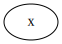

In [ ]:
def test_render_model():
    pyro.sample('x', dist.Normal(loc=1., scale=1.))

pyro.render_model(test_render_model)

In [ ]:
def test_model_output():
    return pyro.sample('x', dist.Normal(loc=output, scale=1.).to_event(1))

test_model_output()


tensor([[[-1.3386,  1.9040,  1.4556, -0.6463,  1.8404],
         [-0.1662,  0.4924,  1.4238,  0.2025, -1.0377],
         [ 0.5525, -0.9430,  2.2313,  0.3538,  0.9349],
         [-1.0124,  0.9550,  1.2699, -1.3351,  1.9547],
         [-0.4112,  0.9581,  0.2245, -0.2406, -0.1525],
         [ 0.2059, -0.1129,  1.5861,  0.0179,  1.3932],
         [ 0.9924, -0.4446,  1.3662,  1.9154, -0.0766],
         [-0.2968,  0.7732, -0.3974, -0.3755,  1.2108],
         [-1.8049, -1.7444,  0.0410, -0.3086, -0.5332],
         [ 0.5124,  0.6758,  0.8302, -0.8636, -0.0899],
         [-0.4996, -2.3154, -0.5562, -0.2404,  1.3829]],

        [[-0.6996,  0.5588, -1.3220, -1.9303,  1.1526],
         [ 0.2007, -1.0267, -1.7316, -1.3529, -0.9049],
         [-1.7431, -0.3407,  0.4383,  0.0301, -0.5620],
         [-0.3037, -0.5802, -0.6130, -1.1913,  0.0889],
         [-0.6633,  0.1565,  1.0390, -1.1949,  1.8005],
         [ 0.4342, -1.5031,  0.6127,  1.0011,  0.3697],
         [-1.2314,  1.0591, -0.2568, -0.6938, 

#### empty_like

In [ ]:
a = torch.empty_like(torch.zeros(3))

In [ ]:
a

tensor([4.7958e-34, 3.0957e-41, 5.3499e-34])

#### matrix + scalar

In [ ]:
a = torch.zeros(2,2)
b = torch.tensor(10)

a + b

tensor([[10., 10.],
        [10., 10.]])

### concat

In [ ]:
x_0 = torch.arange(2*3*5).reshape(2,3,5)
x_0

tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14]],

        [[15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29]]])

In [ ]:
x_lst = [x_0, x_0]

x_lst_d2 = torch.concat(x_lst, dim=-2)
x_lst_d1 = torch.concat(x_lst)

In [ ]:
x_0.shape, x_lst_d2.shape, x_lst_d1.shape

(torch.Size([2, 3, 5]), torch.Size([2, 6, 5]), torch.Size([4, 3, 5]))

### squeeze & unsqueeze

In [ ]:
a = torch.arange(0, 2*3*5).reshape(2,-1)
a

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [ ]:
a.squeeze()

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [ ]:
b=  a.unsqueeze(0)
b.shape

torch.Size([1, 2, 15])

In [ ]:
b= a.unsqueeze(1)
b.shape

torch.Size([2, 1, 15])